# CNN Development

Library Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras import regularizers
from keras import optimizers
from tensorflow.python.client import device_lib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import pickle
import numpy as np
import pandas as pd
import os
import librosa
import soundata
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

C:\Users\pedro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


File Load / Save with Pickle

In [2]:
def save_pkl(data, path):
    with open(path, "wb") as saved_data:
        pickle.dump(data, saved_data)
    saved_data.close()

def load_pkl(path):
    to_return = None
    with open(path, "rb") as loaded_data:
        to_return = pickle.load(loaded_data)
    loaded_data.close()
    return to_return

## Feature Extraction

First of all, we need to load the data. Looking at the metadata from the dataset, we can see the target classes, the folds, and the path to the audio files. We will use the path to load the audio files and extract the features.

In [3]:
data_info = pd.read_csv("C:\\tmp\\sound_datasets\\urbansound8k\\metadata\\UrbanSound8K.csv")
data_info

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


Let's see our class distribution

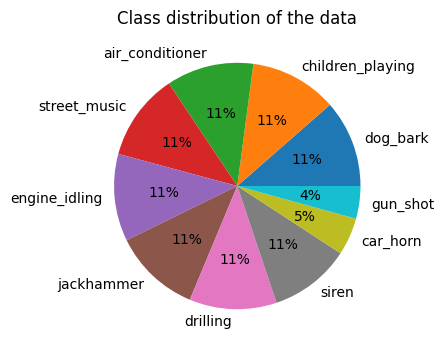

In [4]:
data_info['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(4,4))
plt.title('Class distribution of the data')
plt.ylabel('')
plt.show()

Looks relatively balanced, so, we define some constants in order to preprocess our data:
- The path of the dataset
- The duration in seconds of every audio
- The sample rate we will use to process the audios.
- The hop between frames of audio
- The window of the audio we will analye
- The lenght of the FFT window
- The size of the arrays given the sample rate and the hop lenght

In [5]:
FOLDS_PATH = "C:/tmp/sound_datasets/urbansound8k/audio"
DURATION = 4 # 4 seconds for each audio file
SAMPLE_RATE = 22050
HOP_LENGTH = round(SAMPLE_RATE * 0.0125)
WIN_LENGTH = round(SAMPLE_RATE * 0.023)
N_FFT = 2**10
TIME_SIZE = 4*SAMPLE_RATE//HOP_LENGTH+1

We can see in the previous metadata that some audios are longer than the 4 seconds we want, so we will have to normalize all the audios. That will be done with the following function:

In [6]:
def zero_pad(audio_file_path):
    signal, sample_rate = librosa.load(audio_file_path, sr=None)
    # resample the sample rate to the target value of SR
    signal = librosa.resample(signal, orig_sr=sample_rate, target_sr=SAMPLE_RATE)
    # zero padding
    if len(signal) < DURATION*SAMPLE_RATE:
        signal = np.concatenate([
            signal,
            np.zeros(shape=(DURATION*SAMPLE_RATE - len(signal), ))
        ])
    elif len(signal) > DURATION*SAMPLE_RATE:
        signal = signal[:DURATION*SAMPLE_RATE]
    return signal

It resamples the audio file to the sample rate we chose, and if the lenght is lower than the 4 seconds, it adds empty padding to the end until.  Now with the audios ready to be processed into its features, we will have to choose what features we want.

Let's use librosa and soundata to see the dataset and analyse some features.

In [7]:
dataset = soundata.initialize('urbansound8k')
example_clip = dataset.choice_clip()
inpt = zero_pad(example_clip.audio_path)

### Features & Shapes:

- 2D Mel Spectrogram: (128, 320)

(128, 320)


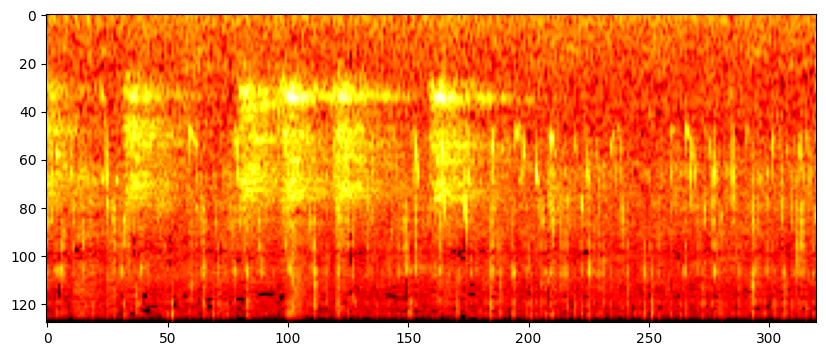

In [8]:
ex = librosa.feature.melspectrogram(y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
ex = librosa.power_to_db(ex, ref=np.max)

print(ex.shape)
plt.figure(figsize=(10, 4))
plt.imshow(ex, cmap='hot')
plt.show()

- 2D Chromagram: (121,320)

(121, 320)


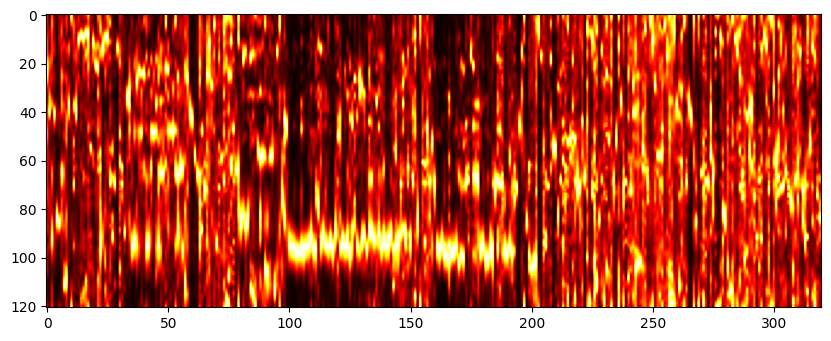

In [9]:
ex = librosa.feature.chroma_stft(y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, n_chroma=121)

print(ex.shape)
plt.figure(figsize=(10, 4))
plt.imshow(ex, cmap='hot')
plt.show()

- 1D Spectral Flatness (320)
- 1D Spectral Bandwidth (320)
- 1D Spectral Rolloff (320)
- 1D Spectral Centroid (320)

Text(0.5, 1.0, 'Spectral Centroid')

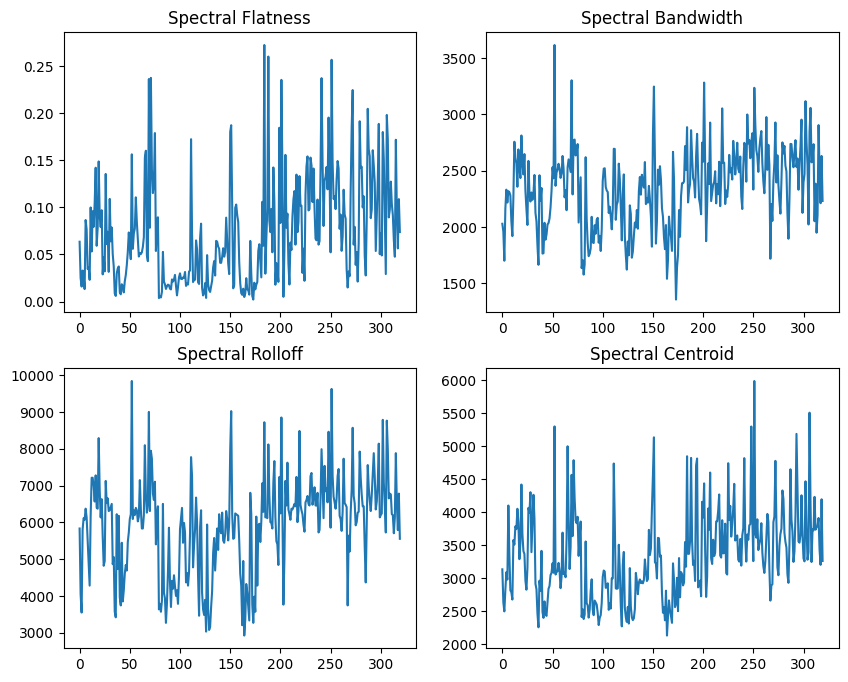

In [10]:
flt = librosa.feature.spectral_flatness(y=inpt, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
bdw = librosa.feature.spectral_bandwidth(y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
rol = librosa.feature.spectral_rolloff(y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
cen = librosa.feature.spectral_centroid(y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)

fig, ax = plt.subplots(2,2,figsize=(10, 8))
ax[0,0].plot(flt[0])
ax[0,0].set_title("Spectral Flatness")
ax[0,1].plot(bdw[0])
ax[0,1].set_title("Spectral Bandwidth")
ax[1,0].plot(rol[0])
ax[1,0].set_title("Spectral Rolloff")
ax[1,1].plot(cen[0])
ax[1,1].set_title("Spectral Centroid")

Looks promising!
Let's go over every audio, extract their class, fold and all the features. Let's also take into account to One Hot Encode the label class for training.

In [11]:
folds = [fold for fold in os.listdir(FOLDS_PATH) if "fold" in fold]
df_data = []
if not os.path.exists("C:\\Users\\pedro\\Documents\\Code\\ML2-Project\\assets\\urbansound8k.pkl"):
    for fold in folds:
        i = 0
        audio_files = librosa.util.find_files(FOLDS_PATH+"/"+fold)
        for audio in audio_files:
            classid = data_info[data_info["slice_file_name"]
                                == audio.split("\\")[-1]]["classID"].values[0]

            inpt = zero_pad(audio)

            mel_spec = librosa.feature.melspectrogram(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            
            choom = librosa.feature.chroma_stft(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, n_chroma=121)

            flt = librosa.feature.spectral_flatness(
                y=inpt, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            bdw = librosa.feature.spectral_bandwidth(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            rol = librosa.feature.spectral_rolloff(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            cen = librosa.feature.spectral_centroid(
                y=inpt, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, win_length=WIN_LENGTH)
            extract = {
                "fold": fold,
                "mel_spec": mel_spec,
                "chroma": choom,
                "spectral_flatness": flt,
                "spectral_bandwidth": bdw,
                "spectral_rolloff": rol,
                "spectral_centroid": cen,
                "target": int(classid)
            }
            if i % 100 == 0:
                print(str(i) + " audios processed out of " + str(len(audio_files)) + " in " + fold)
            df_data.append(extract)
            i += 1

    df_data = pd.DataFrame(df_data, columns=["fold", "mel_spec", "chroma", "spectral_flatness",
                           "spectral_bandwidth", "spectral_rolloff", "spectral_centroid", "target"])
    ohe_targets = np.zeros(
        shape=(df_data['target'].size, df_data['target'].max()+1))
    ohe_targets[np.arange(df_data['target'].size),
                df_data['target'].to_numpy(dtype=np.int16)] = 1
    df_data['target'] = ohe_targets.tolist()
    df_data['target'].apply(np.array)

    save_pkl(
        df_data, "C:\\Users\\pedro\\Documents\\Code\\ML2-Project\\assets\\urbansound8k.pkl")
else:
    df_data = load_pkl(
        "C:\\Users\\pedro\\Documents\\Code\\ML2-Project\\assets\\urbansound8k.pkl")
    print("Previous feature dataset found, loading...")
print("Done.")


Previous feature dataset found, loading...
Done.


Let's save into some variables the future shape of the inputs, as the 1D features will be all stacked, the model input for those will have 4 channels.

In [12]:
mel_shape = (128,320, 1)
chroma_shape = (121,320, 1)
oned_shape = (320,4)

## Model Creation

This will be our model:

As our  classes are relatively balanced, but we don't know the balance between each fold, we will initialize the weights randomly from a normal distribution.

After the three convolutional streams are processed, we will flatten them and concatenate them all into a single layer, then process them in a dense neural network.

In [13]:
def create_model():

  melinput = layers.Input(shape=mel_shape, name = 'mel_spectogram_input')

  mel = layers.Conv2D(16,kernel_size=7,strides=3,padding = "same",activation="relu", kernel_initializer='he_normal')(melinput)
  mel = layers.MaxPooling2D(padding='same',pool_size=(4,4))(mel)
  mel = layers.Dropout(0.4)(mel)
  mel = layers.Conv2D(32,kernel_size=5,strides=1,padding = "same",activation="relu", kernel_initializer='he_normal')(mel)
  mel = layers.MaxPooling2D(padding='same',pool_size=(3,3))(mel)
  mel = layers.Dropout(0.3)(mel)
  mel = layers.Conv2D(64,kernel_size=3,strides=1,padding = "same", activation="relu", kernel_initializer='he_normal')(mel)
  mel = layers.MaxPooling2D(padding='same',pool_size=(2,2))(mel)
  mel = layers.Dropout(0.2)(mel)
  mel = layers.Conv2D(128,kernel_size=3,strides=1,padding = "same",activation="relu", kernel_initializer='he_normal')(mel)
  mel = layers.MaxPooling2D(padding='same',pool_size=(2,2))(mel)
  mel = layers.Dropout(0.2)(mel)
  mel = layers.Flatten()(mel)

  chromainput = layers.Input(shape=chroma_shape, name = 'chromagram_input')

  chroma = layers.Conv2D(16,kernel_size=5,strides=1,activation="relu", kernel_initializer='he_normal')(chromainput)
  chroma = layers.MaxPooling2D(padding='same',pool_size=(3,3))(chroma)
  chroma = layers.Dropout(0.2)(chroma)
  chroma = layers.Conv2D(32,kernel_size=5,strides=1,activation="relu", kernel_initializer='he_normal')(chroma)
  chroma = layers.MaxPooling2D(padding='same',pool_size=(3,3))(chroma)
  chroma = layers.Dropout(0.2)(chroma)
  chroma = layers.Conv2D(64,kernel_size=3,strides=1,activation="relu", kernel_initializer='he_normal')(chroma)
  chroma = layers.MaxPooling2D(padding='same',pool_size=(3,3))(chroma)
  chroma = layers.Dropout(0.2)(chroma)
  chroma = layers.Conv2D(128,kernel_size=3,strides=1,activation="relu", kernel_initializer='he_normal')(chroma)
  chroma = layers.Dropout(0.2)(chroma)
  chroma = layers.Flatten()(chroma)

  onedinput = layers.Input(shape=oned_shape, name = 'one_d_input')

  oned = layers.Conv1D(16,kernel_size=5,strides=1,activation="relu")(onedinput)
  oned = layers.MaxPooling1D(padding='same',pool_size=(2))(oned)
  oned = layers.Dropout(0.2)(oned)
  oned = layers.Conv1D(32,kernel_size=3,strides=1,activation="relu")(oned)
  oned = layers.MaxPooling1D(pool_size=(2))(oned)
  oned = layers.Dropout(0.2)(oned)
  oned = layers.Conv1D(64,kernel_size=3,strides=1,activation="relu")(oned)
  oned = layers.Flatten()(oned) 

  combined = layers.concatenate([mel, chroma, oned])

  combined = layers.Dense(512,activation="relu", kernel_regularizer = regularizers.l2(l=0.05), kernel_initializer='he_normal')(combined)
  combined = layers.Dropout(0.2)(combined)
  combined = layers.Dense(512,activation="relu", kernel_regularizer = regularizers.l2(l=0.05), kernel_initializer='he_normal')(combined)
  combined = layers.Dropout(0.2)(combined)
  combined = layers.Dense(256,activation="relu", kernel_regularizer = regularizers.l2(l=0.05), kernel_initializer='he_normal')(combined)

  output = layers.Dense(10, activation='softmax')(combined)

  model = keras.Model(inputs=[melinput, chromainput, onedinput], outputs=[output])

  return model

In [14]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mel_spectogram_input (Inpu  [(None, 128, 320, 1)]        0         []                            
 tLayer)                                                                                          
                                                                                                  
 conv2d (Conv2D)             (None, 43, 107, 16)          800       ['mel_spectogram_input[0][0]']
                                                                                                  
 chromagram_input (InputLay  [(None, 121, 320, 1)]        0         []                            
 er)                                                                                              
                                                                                              

4 million parameters, given our previous tries (90 million or more parameters), this should be relatively fast.

We can also plot the graph of our CNN:

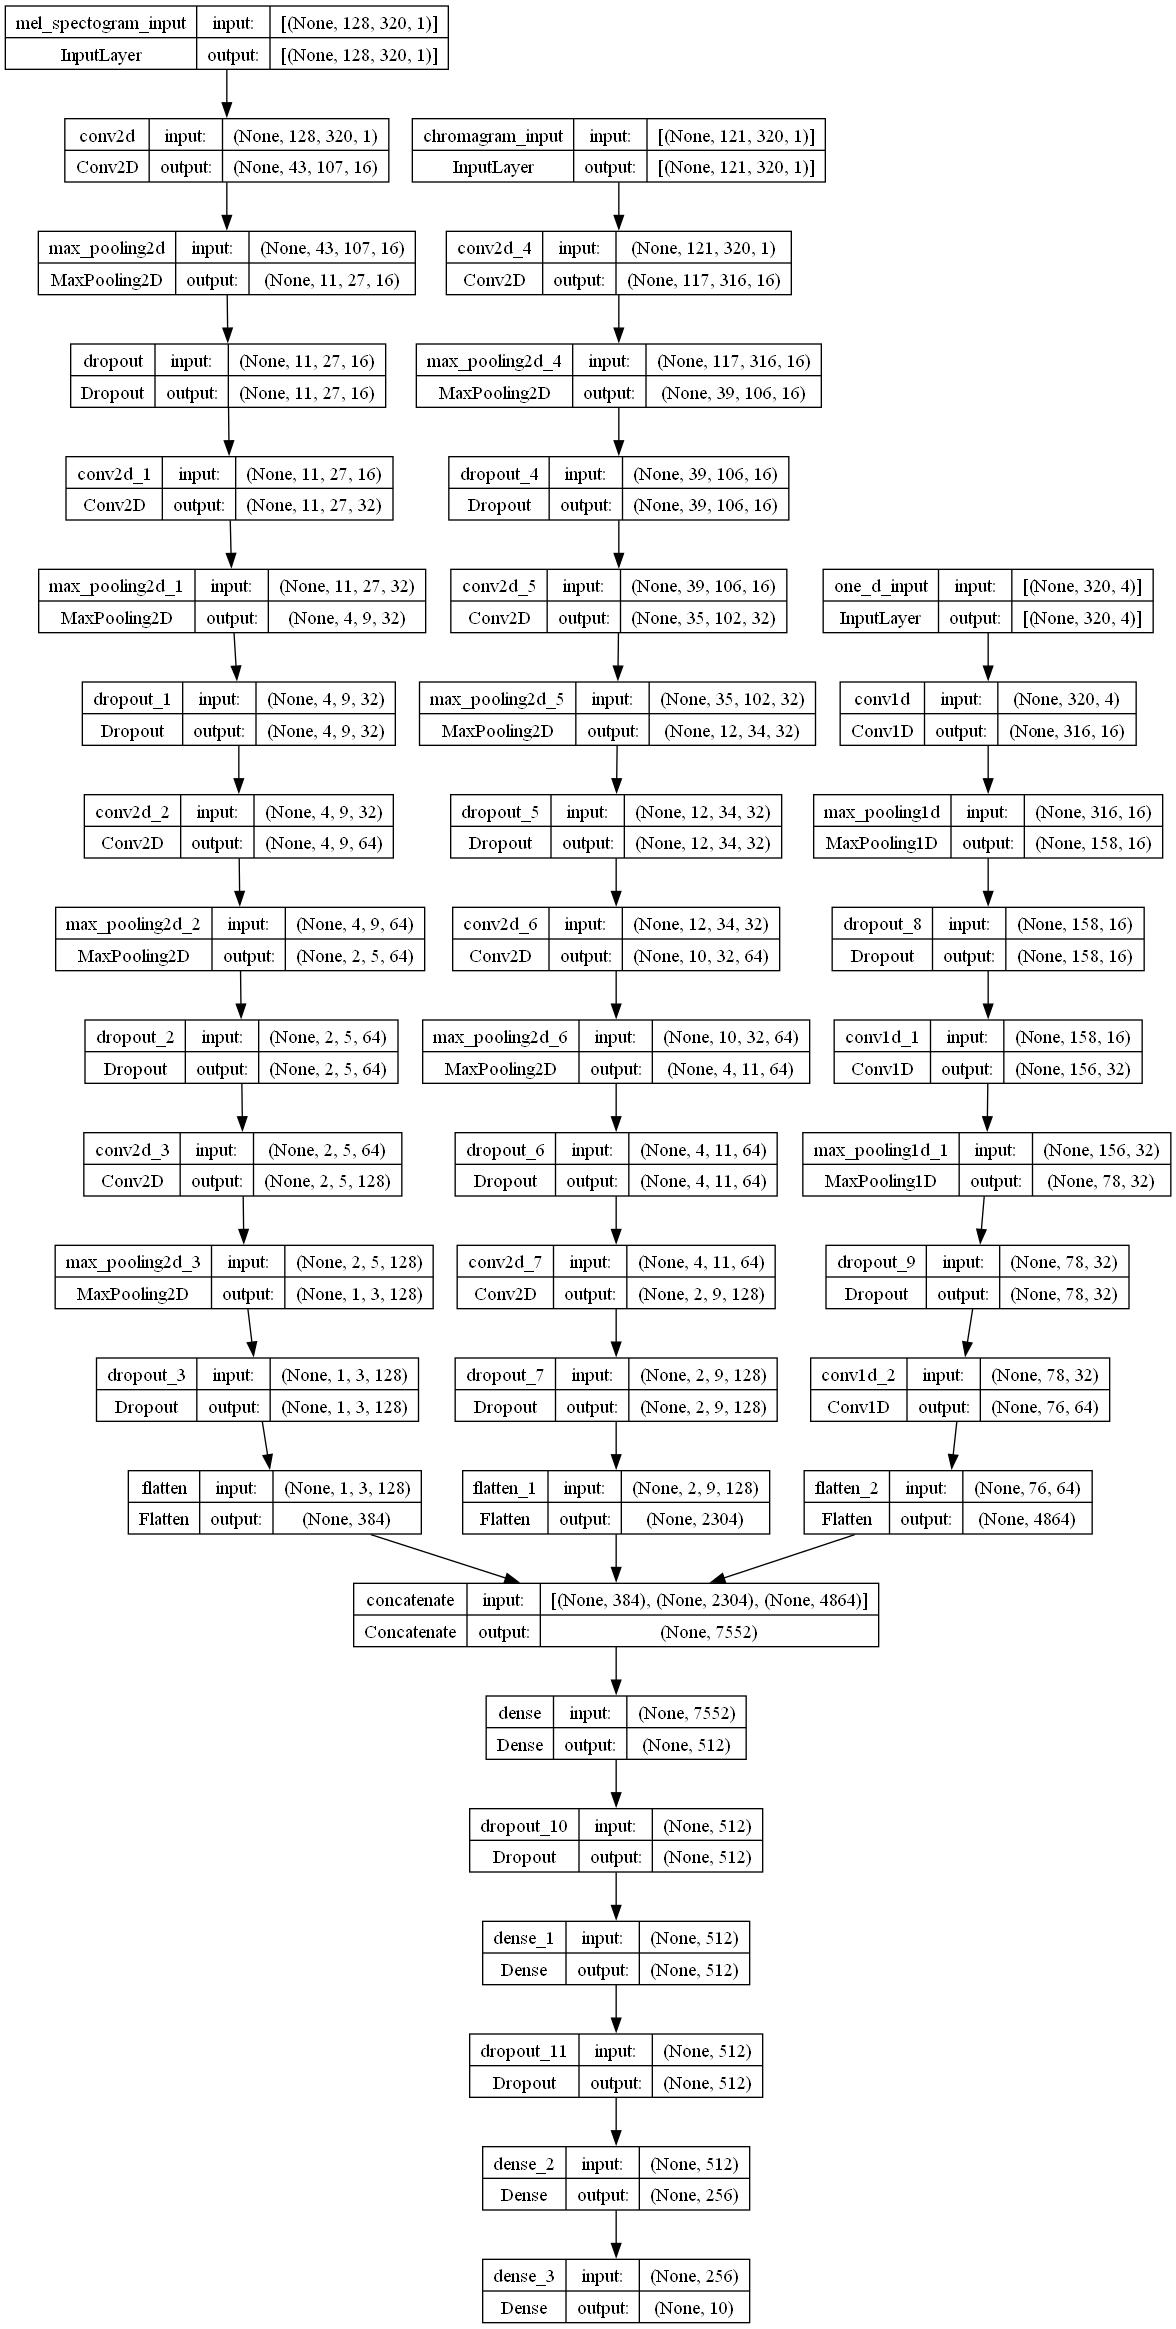

In [15]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

## Data Reshaping

With our model ready to be trained, we just have to separate our data into the training, testing and validation sets. We will also reshape the 1D data to become a NumPy stack.

In [16]:
def ready_data(fold):
    X_test = df_data[df_data["fold"] == fold]
    X_train = df_data[df_data["fold"] != fold]

    y_train = X_train["target"]
    X_train = X_train.drop(columns=["fold"])

    X_test, X_val, y_test, y_val = train_test_split(X_test.drop(columns=["fold"]), X_test["target"], test_size=0.5, random_state=42)

    X_train_mel = np.asarray(X_train["mel_spec"].to_list()).astype(np.float32)
    X_train_chroma = np.asarray(X_train["chroma"].to_list()).astype(np.float32)

    a = np.asarray(tuple(X_train["spectral_centroid"].to_list())).astype(np.float32)
    b = np.asarray(tuple(X_train["spectral_bandwidth"].to_list())).astype(np.float32)
    c = np.asarray(tuple(X_train["spectral_flatness"].to_list())).astype(np.float32)
    d = np.asarray(tuple(X_train["spectral_rolloff"].to_list())).astype(np.float32)

    X_train_1d = np.stack([a,b,c,d], axis=-1)
    X_train_1d = X_train_1d.reshape(-1, TIME_SIZE, 4)

    a = np.asarray(tuple(X_val["spectral_centroid"].to_list())).astype(np.float32)
    b = np.asarray(tuple(X_val["spectral_bandwidth"].to_list())).astype(np.float32)
    c = np.asarray(tuple(X_val["spectral_flatness"].to_list())).astype(np.float32)
    d = np.asarray(tuple(X_val["spectral_rolloff"].to_list())).astype(np.float32)

    X_val_1d = np.stack([a,b,c,d], axis=-1)
    X_val_1d = X_val_1d.reshape(-1, TIME_SIZE, 4)

    a = np.asarray(tuple(X_test["spectral_centroid"].to_list())).astype(np.float32)
    b = np.asarray(tuple(X_test["spectral_bandwidth"].to_list())).astype(np.float32)
    c = np.asarray(tuple(X_test["spectral_flatness"].to_list())).astype(np.float32)
    d = np.asarray(tuple(X_test["spectral_rolloff"].to_list())).astype(np.float32)

    X_test_1d = np.stack([a,b,c,d], axis=-1)
    X_test_1d = X_test_1d.reshape(-1, TIME_SIZE, 4) 

    X_val_mel = np.asarray(X_val["mel_spec"].to_list()).astype(np.float32)
    X_val_chroma = np.asarray(X_val["chroma"].to_list()).astype(np.float32)
    X_test_mel = np.asarray(X_test["mel_spec"].to_list()).astype(np.float32)
    X_test_chroma = np.asarray(X_test["chroma"].to_list()).astype(np.float32)
    y_train = np.asarray(y_train.to_list()).astype(np.float32)
    y_val = np.asarray(y_val.to_list()).astype(np.float32)	
    y_test = np.asarray(y_test.to_list()).astype(np.float32)

    del X_train
    del X_val
    del X_test
    del a
    del b
    del c
    del d

    return X_train_mel, X_train_chroma, X_train_1d, y_train, X_val_mel, X_val_chroma, X_val_1d, y_val, X_test_mel, X_test_chroma, X_test_1d, y_test

## Metric Variables

And, to analyse the 10 models made in the 10 fold cross validation, we will keep useful info in some arrays.

In [17]:
fold_metrics = []
models = []

## 10-Fold Cross Validation

The model will be fit using the Adam optimizar, we will use categorical (hence why we one hot encoded the class labels) crossentropy as our loss function, and we will use accuracy to analyse how well our model performs.

We will also input the data in batches of 64, and, from previous testings, we will define the number of epochs to 50, as more start to take too much time to train with a low yield of results.

In [18]:
EPOCHS = 50

for i in range(4,11): # 1-3 done in previous run
    fold = "fold"+str(i)
    print("Fold "+str(i)+":")

    model = create_model()

    X_train_mel, X_train_chroma, X_train_1d, y_train, X_val_mel, X_val_chroma, X_val_1d, y_val, X_test_mel, X_test_chroma, X_test_1d, y_test = ready_data(fold)

    adam = optimizers.Adam(lr=0.001)
    
    model.compile(
        optimizer=adam,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    a = model.fit(
        {'mel_spectogram_input': X_train_mel, 'chromagram_input': X_train_chroma, 'one_d_input': X_train_1d},
        validation_data=({'mel_spectogram_input': X_val_mel, 'chromagram_input': X_val_chroma, 'one_d_input': X_val_1d}, y_val),
        y = y_train,
        epochs=EPOCHS,
        batch_size = 64
    )

    evaluation = model.evaluate(x={'mel_spectogram_input': X_test_mel, 'chromagram_input': X_test_chroma, 'one_d_input': X_test_1d}, y=y_test)
    y_pred = model.predict(x={'mel_spectogram_input': X_test_mel, 'chromagram_input': X_test_chroma, 'one_d_input': X_test_1d})

    y_pred_reshape = np.argmax(y_pred, axis=1)
    y_test_reshape = np.argmax(y_test, axis=1)

    m_metrics = {'loss': evaluation[0], 'accuracy': evaluation[1], 'confusion_matrix': confusion_matrix(y_test_reshape, y_pred_reshape), 'history': model, 'history_dict': a.history}
    fold_metrics.append(m_metrics)

    save_pkl(m_metrics, f"assets/kfold_metrics/metrics_fold{i}.pkl")

    model.save(f"assets/kfold_metrics/model_fold{i}.keras", save_format="keras")
    
    models.append(a)

    del model # restart model to avoid memory leakage

save_pkl(fold_metrics, "assets/kfold_metrics/metrics.pkl")
save_pkl(models, "assets/kfold_metrics/models.pkl")

print("Done.")




Fold 1:


Epoch 1/50



123/123 [==============================] - 37s 268ms/step - loss: 228.0983 - accuracy: 0.1470 - val_loss: 94.8241 - val_accuracy: 0.1442
Epoch 2/50
123/123 [==============================] - 33s 266ms/step - loss: 87.1459 - accuracy: 0.1764 - val_loss: 81.1201 - val_accuracy: 0.1533
Epoch 3/50
123/123 [==============================] - 34s 276ms/step - loss: 76.2803 - accuracy: 0.2238 - val_loss: 71.7478 - val_accuracy: 0.2334
Epoch 4/50
123/123 [==============================] - 33s 271ms/step - loss: 67.8596 - accuracy: 0.2547 - val_loss: 64.3045 - val_accuracy: 0.3135
Epoch 5/50
123/123 [==============================] - 34s 280ms/step - loss: 60.9989 - accuracy: 0.2765 - val_loss: 57.8764 - val_accuracy: 0.3730
Epoch 6/50
123/123 [==============================] - 33s 265ms/step - loss: 55.1741 - accuracy: 0.2864 - val_loss: 52.5185 - val_accuracy: 0.3318
Epoch 7/50
123/123 [==============================] - 32s 260ms/step - loss: 50.1277 - accuracy: 0.2983 - val_loss: 47.8440 - va

Epoch 1/50
123/123 [==============================] - 38s 277ms/step - loss: 278.7392 - accuracy: 0.1432 - val_loss: 98.5852 - val_accuracy: 0.1486
Epoch 2/50
123/123 [==============================] - 31s 254ms/step - loss: 92.6394 - accuracy: 0.1736 - val_loss: 87.0036 - val_accuracy: 0.2275
Epoch 3/50
123/123 [==============================] - 31s 254ms/step - loss: 82.5505 - accuracy: 0.1961 - val_loss: 78.2449 - val_accuracy: 0.1914
Epoch 4/50
123/123 [==============================] - 31s 253ms/step - loss: 74.4825 - accuracy: 0.2149 - val_loss: 70.9359 - val_accuracy: 0.2072
Epoch 5/50
123/123 [==============================] - 31s 252ms/step - loss: 67.7147 - accuracy: 0.2341 - val_loss: 64.9166 - val_accuracy: 0.2838
Epoch 6/50
123/123 [==============================] - 31s 254ms/step - loss: 62.0137 - accuracy: 0.2640 - val_loss: 59.5971 - val_accuracy: 0.2950
Epoch 7/50
123/123 [==============================] - 31s 252ms/step - loss: 56.9875 - accuracy: 0.2649 - val_loss: 5

Epoch 1/50
122/122 [==============================] - 35s 258ms/step - loss: 203.3822 - accuracy: 0.1545 - val_loss: 95.8124 - val_accuracy: 0.1857
Epoch 2/50
122/122 [==============================] - 31s 250ms/step - loss: 88.5248 - accuracy: 0.1832 - val_loss: 81.9624 - val_accuracy: 0.1469
Epoch 3/50
122/122 [==============================] - 31s 251ms/step - loss: 76.7331 - accuracy: 0.2030 - val_loss: 71.7099 - val_accuracy: 0.1663
Epoch 4/50
122/122 [==============================] - 30s 250ms/step - loss: 67.5518 - accuracy: 0.2133 - val_loss: 63.6007 - val_accuracy: 0.2009
Epoch 5/50
122/122 [==============================] - 31s 250ms/step - loss: 60.0835 - accuracy: 0.2230 - val_loss: 56.7494 - val_accuracy: 0.2138
Epoch 6/50
122/122 [==============================] - 30s 245ms/step - loss: 53.8347 - accuracy: 0.2344 - val_loss: 51.0483 - val_accuracy: 0.1641
Epoch 7/50
122/122 [==============================] - 30s 243ms/step - loss: 48.4902 - accuracy: 0.2300 - val_loss: 4

KeyboardInterrupt: 

## Model Analysis

### Accuracy & Loss 

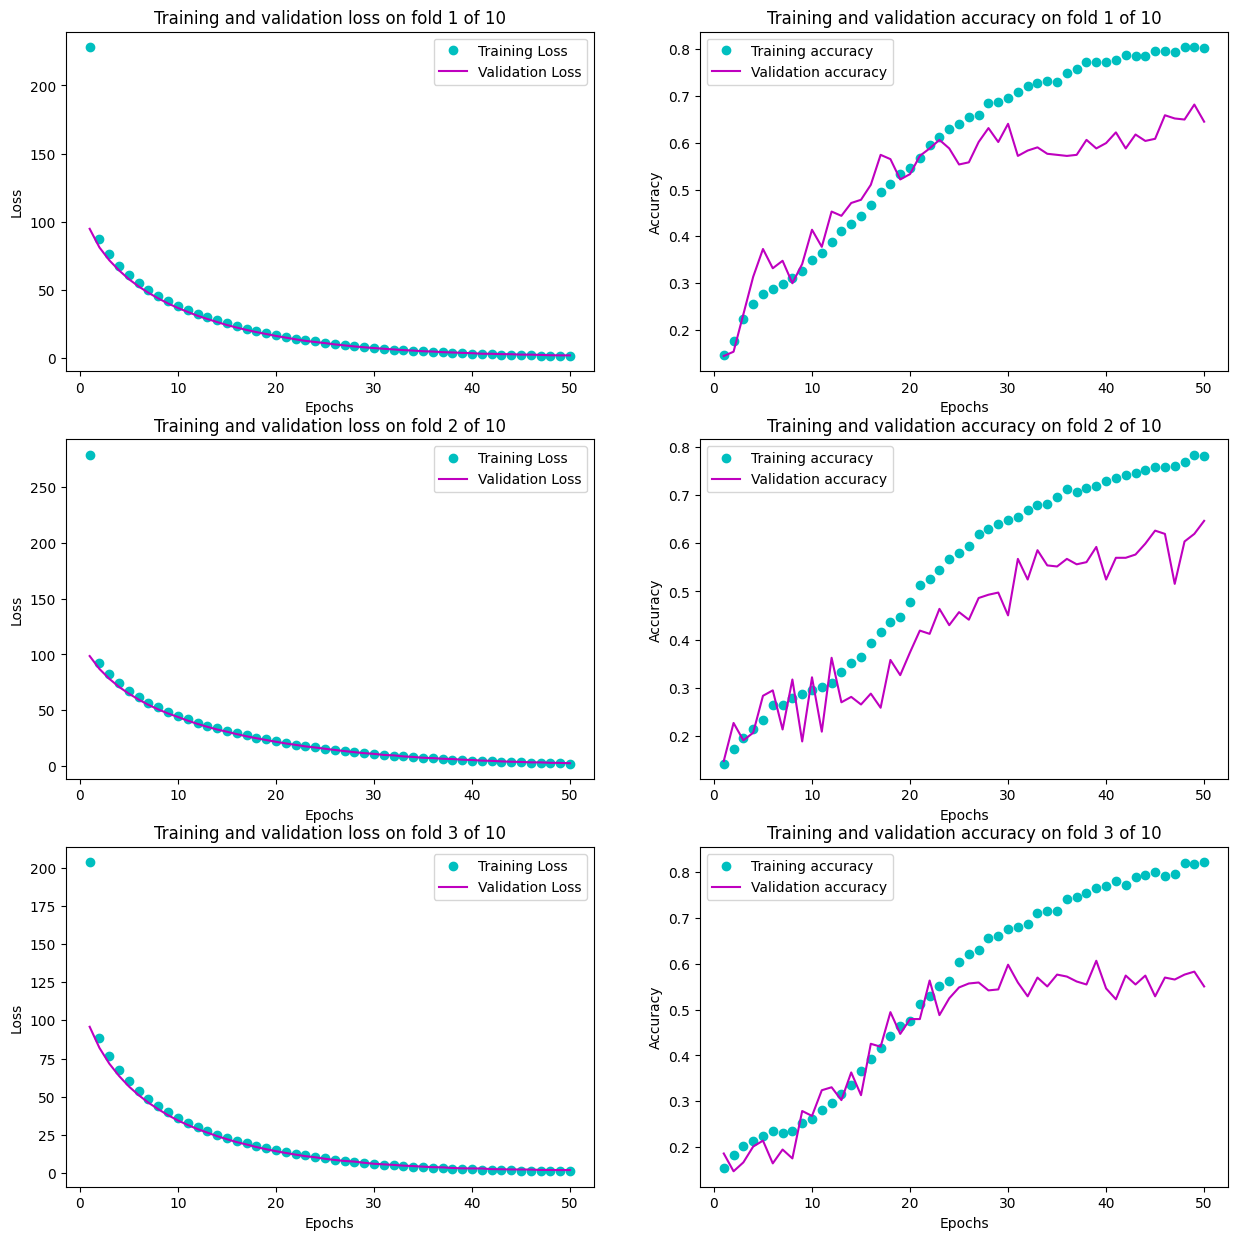

0.6450766722361246 average validation accuracy across all folds.


In [31]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
import matplotlib.pyplot as plt
epochs = range(1,EPOCHS + 1)

fig, ax =plt.subplots(3,2,figsize=(15,5*len(models)))

for i in range(0,len(models)):
    history_dict = models[i].history
    loss_values=history_dict['loss']
    acc_values=history_dict['accuracy']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    ax[i,0].plot(epochs,loss_values,'co',label='Training Loss')
    ax[i,0].plot(epochs,val_loss_values,'m', label='Validation Loss')
    ax[i,0].set_title('Training and validation loss on fold '+str(i+1)+' of 10')
    ax[i,0].set_xlabel('Epochs')
    ax[i,0].set_ylabel('Loss')
    ax[i,0].legend()

    ax[i,1].plot(epochs,acc_values,'co', label='Training accuracy')
    ax[i,1].plot(epochs,val_acc_values,'m', label='Validation accuracy')
    ax[i,1].set_title('Training and validation accuracy on fold '+str(i+1)+' of 10')
    ax[i,1].set_xlabel('Epochs')
    ax[i,1].set_ylabel('Accuracy')
    ax[i,1].legend()
plt.show()


avg_val_acc = 0

for i in models:
    avg_val_acc += max(i.history['val_accuracy'])

print(str(avg_val_acc / len(models)) + " average validation accuracy across all folds.")

### Confusion Matrix

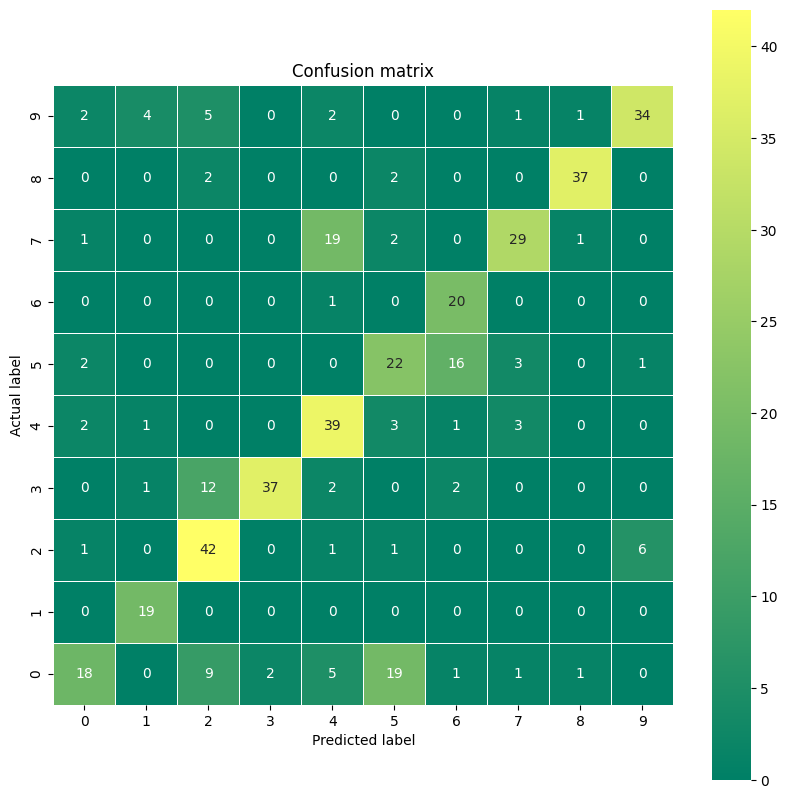

In [21]:
import seaborn as sns
cm = confusion_matrix(y_test_reshape, y_pred_reshape)
plt.figure(figsize=(10,10))
ax = sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'summer')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
ax.invert_yaxis()
plt.title('Confusion matrix')
plt.show()
